## Testing Surrogated-Sources Approach

In [566]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

from scipy.integrate import solve_ivp

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [567]:
### Input Data

#OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_10PSR_Clean/'
OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_PSR_Clean_Test/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data_PSR_Clean_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NVarsRed           = 3

NPerRestTrain      = 1000
tStratch           = 1.
NtTrain            = NPerRestTrain*2
SOLVER             = 'RK23'

NNeurons           = [16,32,64,32,16]
Activations        = [activations.tanh, activations.tanh, activations.tanh, activations.tanh, activations.tanh]
NEpoch             = 5000
NBatch             = 64
LearningRate       = 1.e-3
OptimizerName      = tf.optimizers.Adam

In [568]:
### Retrieving Data

Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    
# NRests             = 10
# for iRest in range(NRests):

#     FileName     = OutputDir+'/pc_data_3/PC.csv.'+str(iRest+1) 
#     Data         = pd.read_csv(FileName, header=0)
#     tVec         = Data['t'].to_numpy()
#     yMat         = Data[Vars].to_numpy()
    
#     FileName     = OutputDir+'/pc_data_3/PCSource.csv.'+str(iRest+1) 
#     DataS        = pd.read_csv(FileName, header=0)
#     ySource      = DataS[SVars].to_numpy()
    
FileName     = OutputDir + '/orig_data/yCleaned.csv'
yMatOrig     = pd.read_csv(FileName, header=0)
VarNames     = list(yMatOrig.columns)
yMat         = yMatOrig.to_numpy()

FileName     = OutputDir + '/orig_data/RestVecTot.csv'
Data         = pd.read_csv(FileName, header=None)
RestVecTot   = np.log10(Data.to_numpy())
    
FileName     = OutputDir+'/orig_data/t.csv'
Data         = pd.read_csv(FileName, header=None)
tVec         = Data.to_numpy()[:,0]

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PC.csv'
Data         = pd.read_csv(FileName, header=0)
yMat_pca     = Data[Vars].to_numpy()

FileName     = OutputDir+'/pc_data_'+str(NVarsRed)+'/PCSource.csv'
DataS        = pd.read_csv(FileName, header=0)
ySource_pca  = DataS[SVars].to_numpy()

Text(0.5, 0, '$dPC_3/dt$')

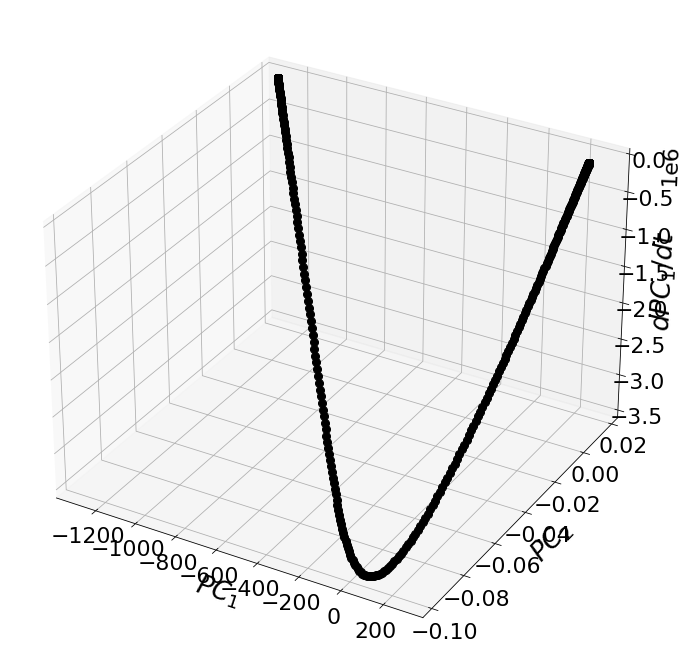

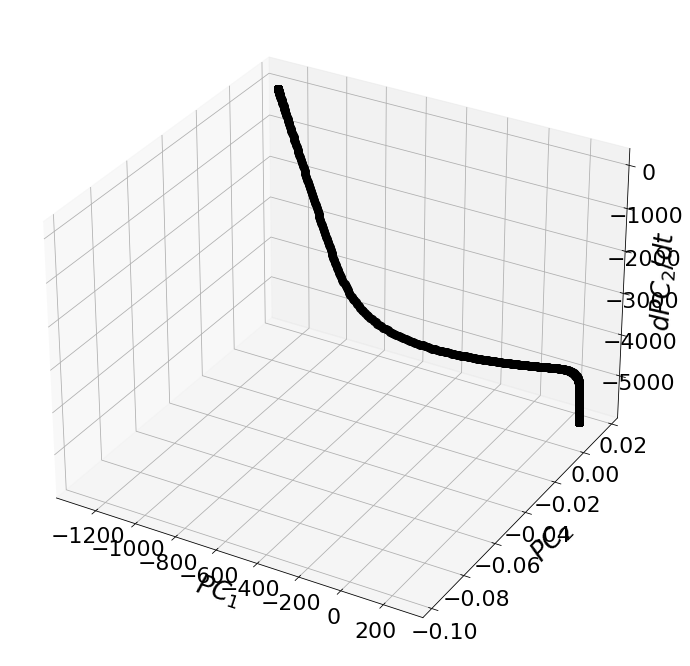

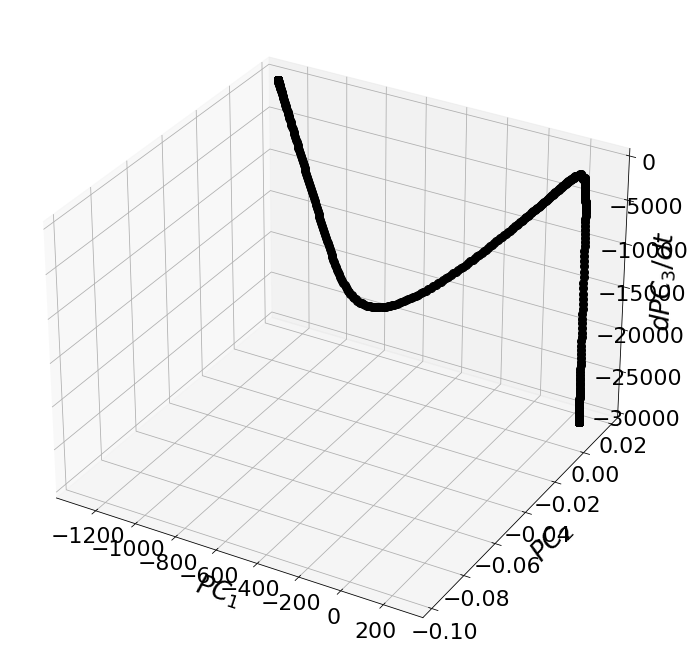

In [569]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], yMat_pca[:,1], ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

In [570]:
### Normalizing Data

yMat_pca  = np.concatenate((yMat_pca, RestVecTot), axis=1)
xMax      = yMat_pca.max(0)
xMin      = yMat_pca.min(0)
xRange    = (xMax-xMin)
if (xRange[-1] == 0):
    xRange[-1] = 1.0
yMatt_pca = (yMat_pca-xMin)/xRange

yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
ySourcee_pca = (ySource_pca-yMin)/yRange

Nx = yMatt_pca.shape[1]
Nd = yMatt_pca.shape[0]
Ny = ySourcee_pca.shape[1]

In [571]:
xRange

array([1.55708113e+03, 1.13246256e-01, 5.92541874e-03, 1.00000000e+00])

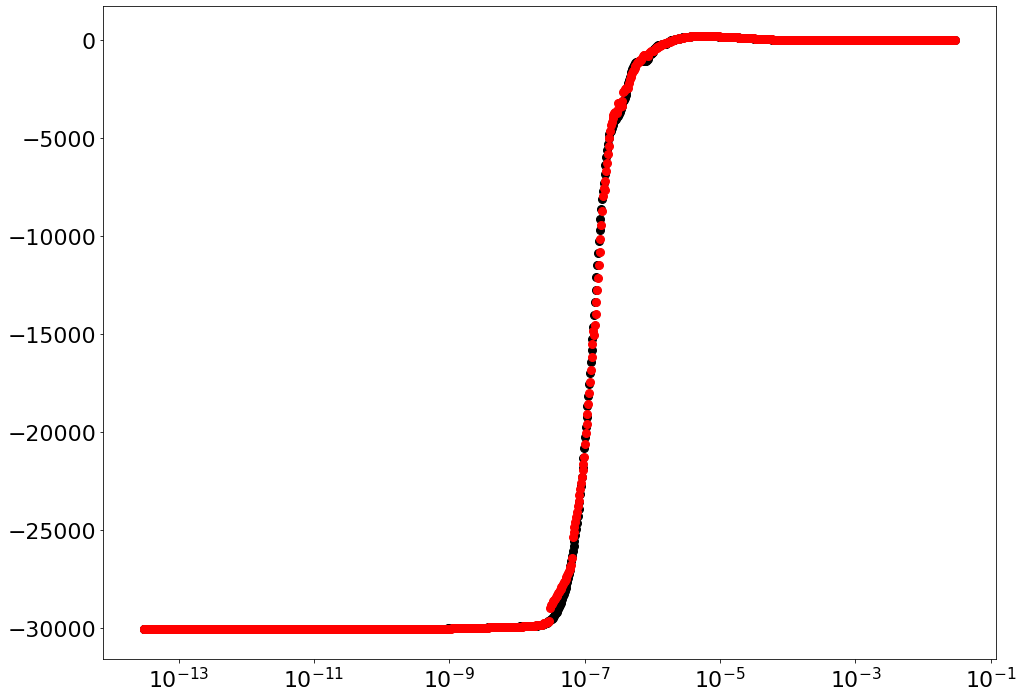

In [572]:
### Checking Data

from numpy import diff

iPC = 2

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[1:], dydt, 'ro')
plt.xscale('log')

In [573]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt_pca, ySourcee_pca, test_size=0.2, random_state=3)

In [574]:
### Creating Surrogate

LengthScale               = 5.e-2
Tau                       = 1.
RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_223 (Dense)            (None, 32)                544       
_________________________________________________________________
dense_224 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_225 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_226 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_227 (Dense)            (None, 3)                 51        
Total params: 5,395
Trainable params: 5,395
Non-trainable params: 0
___________________________________________________

In [575]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training  = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

Epoch 1/5000
13/13 [==============================] - 1s 16ms/step - loss: 0.2462 - val_loss: 0.1872
Epoch 2/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.1343 - val_loss: 0.1233
Epoch 3/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.0935 - val_loss: 0.0831
Epoch 4/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.0617 - val_loss: 0.0504
Epoch 5/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.0247
Epoch 6/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0118
Epoch 7/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 8/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 9/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 10/5000
13/13 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.001

13/13 [==============================] - 0s 5ms/step - loss: 8.9164e-04 - val_loss: 9.4728e-04
Epoch 80/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.2579e-04 - val_loss: 0.0013
Epoch 81/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.8022e-04 - val_loss: 8.9222e-04
Epoch 82/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.4821e-04 - val_loss: 0.0011
Epoch 83/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.8101e-04 - val_loss: 0.0011
Epoch 84/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.1910e-04 - val_loss: 0.0010
Epoch 85/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.2589e-04 - val_loss: 0.0012
Epoch 86/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.1419e-04 - val_loss: 8.9060e-04
Epoch 87/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.0653e-04 - val_loss: 9.7948e-04
Epoch 88/5000
13/13 [==============================] 

13/13 [==============================] - 0s 15ms/step - loss: 9.9364e-04 - val_loss: 0.0012
Epoch 156/5000
13/13 [==============================] - 0s 9ms/step - loss: 8.2995e-04 - val_loss: 8.8507e-04
Epoch 157/5000
13/13 [==============================] - 0s 9ms/step - loss: 8.2893e-04 - val_loss: 0.0012
Epoch 158/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.5850e-04 - val_loss: 9.2017e-04
Epoch 159/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.4970e-04 - val_loss: 8.7359e-04
Epoch 160/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.4825e-04 - val_loss: 8.3878e-04
Epoch 161/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.6920e-04 - val_loss: 9.7738e-04
Epoch 162/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.2002e-04 - val_loss: 8.4824e-04
Epoch 163/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.0763e-04 - val_loss: 0.0012
Epoch 164/5000
13/13 [==============

13/13 [==============================] - 0s 7ms/step - loss: 9.0523e-04 - val_loss: 0.0011
Epoch 231/5000
13/13 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 8.8272e-04
Epoch 232/5000
13/13 [==============================] - 0s 8ms/step - loss: 9.7348e-04 - val_loss: 0.0014
Epoch 233/5000
13/13 [==============================] - 0s 8ms/step - loss: 9.6005e-04 - val_loss: 0.0015
Epoch 234/5000
13/13 [==============================] - 0s 8ms/step - loss: 8.7655e-04 - val_loss: 7.7130e-04
Epoch 235/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.6772e-04 - val_loss: 7.6379e-04
Epoch 236/5000
13/13 [==============================] - 0s 7ms/step - loss: 8.1784e-04 - val_loss: 0.0011
Epoch 237/5000
13/13 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 8.0893e-04
Epoch 238/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.7901e-04 - val_loss: 0.0011
Epoch 239/5000
13/13 [==============================]

13/13 [==============================] - 0s 9ms/step - loss: 3.1026e-04 - val_loss: 3.3590e-04
Epoch 305/5000
13/13 [==============================] - 0s 9ms/step - loss: 3.0699e-04 - val_loss: 3.3056e-04
Epoch 306/5000
13/13 [==============================] - 0s 8ms/step - loss: 3.2254e-04 - val_loss: 3.3431e-04
Epoch 307/5000
13/13 [==============================] - 0s 7ms/step - loss: 3.0683e-04 - val_loss: 3.3612e-04
Epoch 308/5000
13/13 [==============================] - 0s 6ms/step - loss: 3.0059e-04 - val_loss: 3.1560e-04
Epoch 309/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.9828e-04 - val_loss: 3.2111e-04
Epoch 310/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.9118e-04 - val_loss: 3.0912e-04
Epoch 311/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.9102e-04 - val_loss: 3.3451e-04
Epoch 312/5000
13/13 [==============================] - 0s 6ms/step - loss: 3.0280e-04 - val_loss: 3.2041e-04
Epoch 313/5000
13/13 [===

13/13 [==============================] - 0s 18ms/step - loss: 2.2599e-04 - val_loss: 2.2282e-04
Epoch 379/5000
13/13 [==============================] - 0s 10ms/step - loss: 2.2818e-04 - val_loss: 2.2619e-04
Epoch 380/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2449e-04 - val_loss: 2.0984e-04
Epoch 381/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2276e-04 - val_loss: 2.1014e-04
Epoch 382/5000
13/13 [==============================] - 0s 5ms/step - loss: 2.5619e-04 - val_loss: 2.1283e-04
Epoch 383/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.7112e-04 - val_loss: 2.5674e-04
Epoch 384/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.5773e-04 - val_loss: 2.9788e-04
Epoch 385/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.3354e-04 - val_loss: 2.3640e-04
Epoch 386/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.5397e-04 - val_loss: 2.9766e-04
Epoch 387/5000
13/13 [=

13/13 [==============================] - 0s 6ms/step - loss: 3.7336e-04 - val_loss: 8.1515e-04
Epoch 453/5000
13/13 [==============================] - 0s 7ms/step - loss: 4.4956e-04 - val_loss: 3.4880e-04
Epoch 454/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.2897e-04 - val_loss: 2.1750e-04
Epoch 455/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0326e-04 - val_loss: 2.1973e-04
Epoch 456/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0297e-04 - val_loss: 1.9381e-04
Epoch 457/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0201e-04 - val_loss: 2.0447e-04
Epoch 458/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.1769e-04 - val_loss: 1.9237e-04
Epoch 459/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.1161e-04 - val_loss: 1.9561e-04
Epoch 460/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9944e-04 - val_loss: 2.1095e-04
Epoch 461/5000
13/13 [===

13/13 [==============================] - 0s 8ms/step - loss: 1.8882e-04 - val_loss: 2.0733e-04
Epoch 527/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1161e-04 - val_loss: 2.0485e-04
Epoch 528/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1244e-04 - val_loss: 2.0746e-04
Epoch 529/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9988e-04 - val_loss: 2.0425e-04
Epoch 530/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8893e-04 - val_loss: 1.8542e-04
Epoch 531/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8912e-04 - val_loss: 2.2333e-04
Epoch 532/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.1127e-04 - val_loss: 1.8654e-04
Epoch 533/5000
13/13 [==============================] - 0s 16ms/step - loss: 1.9817e-04 - val_loss: 1.9001e-04
Epoch 534/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.1267e-04 - val_loss: 2.6145e-04
Epoch 535/5000
13/13 [==

13/13 [==============================] - 0s 7ms/step - loss: 2.1517e-04 - val_loss: 2.1553e-04
Epoch 601/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.8246e-04 - val_loss: 2.7966e-04
Epoch 602/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.3752e-04 - val_loss: 3.4155e-04
Epoch 603/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.2082e-04 - val_loss: 1.9034e-04
Epoch 604/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.0672e-04 - val_loss: 1.8418e-04
Epoch 605/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9321e-04 - val_loss: 2.1441e-04
Epoch 606/5000
13/13 [==============================] - 0s 7ms/step - loss: 2.3576e-04 - val_loss: 1.8786e-04
Epoch 607/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8341e-04 - val_loss: 1.8299e-04
Epoch 608/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9034e-04 - val_loss: 1.9026e-04
Epoch 609/5000
13/13 [===

13/13 [==============================] - 0s 6ms/step - loss: 1.8615e-04 - val_loss: 2.2026e-04
Epoch 675/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8930e-04 - val_loss: 1.7622e-04
Epoch 676/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9103e-04 - val_loss: 2.2453e-04
Epoch 677/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0941e-04 - val_loss: 1.9094e-04
Epoch 678/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9379e-04 - val_loss: 1.9477e-04
Epoch 679/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8192e-04 - val_loss: 1.8536e-04
Epoch 680/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.7596e-04 - val_loss: 1.8722e-04
Epoch 681/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.8123e-04 - val_loss: 1.7286e-04
Epoch 682/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.7329e-04 - val_loss: 1.7294e-04
Epoch 683/5000
13/13 [===

13/13 [==============================] - 0s 7ms/step - loss: 1.9472e-04 - val_loss: 1.7417e-04
Epoch 749/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9559e-04 - val_loss: 2.1179e-04
Epoch 750/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9160e-04 - val_loss: 1.8811e-04
Epoch 751/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.7365e-04 - val_loss: 1.7629e-04
Epoch 752/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8127e-04 - val_loss: 1.8652e-04
Epoch 753/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.9162e-04 - val_loss: 1.9868e-04
Epoch 754/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8794e-04 - val_loss: 1.9416e-04
Epoch 755/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8482e-04 - val_loss: 2.0725e-04
Epoch 756/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9008e-04 - val_loss: 1.9292e-04
Epoch 757/5000
13/13 [===

13/13 [==============================] - 0s 6ms/step - loss: 1.7263e-04 - val_loss: 1.6982e-04
Epoch 823/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.7344e-04 - val_loss: 2.0451e-04
Epoch 824/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8211e-04 - val_loss: 1.7064e-04
Epoch 825/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9340e-04 - val_loss: 2.4121e-04
Epoch 826/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.1304e-04 - val_loss: 1.7653e-04
Epoch 827/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.2016e-04 - val_loss: 2.0250e-04
Epoch 828/5000
13/13 [==============================] - 0s 6ms/step - loss: 2.0734e-04 - val_loss: 2.1262e-04
Epoch 829/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.9258e-04 - val_loss: 1.7416e-04
Epoch 830/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.7502e-04 - val_loss: 1.9680e-04
Epoch 831/5000
13/13 [===

13/13 [==============================] - 0s 6ms/step - loss: 1.6032e-04 - val_loss: 1.6157e-04
Epoch 897/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.6289e-04 - val_loss: 1.5733e-04
Epoch 898/5000
13/13 [==============================] - 0s 13ms/step - loss: 1.6367e-04 - val_loss: 1.6176e-04
Epoch 899/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.8285e-04 - val_loss: 1.6775e-04
Epoch 900/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.7964e-04 - val_loss: 1.6819e-04
Epoch 901/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.6521e-04 - val_loss: 1.6326e-04
Epoch 902/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.8406e-04 - val_loss: 1.9812e-04
Epoch 903/5000
13/13 [==============================] - 0s 8ms/step - loss: 2.0901e-04 - val_loss: 1.7505e-04
Epoch 904/5000
13/13 [==============================] - 0s 12ms/step - loss: 1.7298e-04 - val_loss: 1.7892e-04
Epoch 905/5000
13/13 [

13/13 [==============================] - 0s 6ms/step - loss: 1.6239e-04 - val_loss: 1.6555e-04
Epoch 971/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.6501e-04 - val_loss: 1.7596e-04
Epoch 972/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.6491e-04 - val_loss: 1.5959e-04
Epoch 973/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.5965e-04 - val_loss: 1.5692e-04
Epoch 974/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.8304e-04 - val_loss: 1.6577e-04
Epoch 975/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.6465e-04 - val_loss: 1.6143e-04
Epoch 976/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.7465e-04 - val_loss: 2.8289e-04
Epoch 977/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.8759e-04 - val_loss: 1.7445e-04
Epoch 978/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.7009e-04 - val_loss: 1.7264e-04
Epoch 979/5000
13/13 [==

13/13 [==============================] - 0s 8ms/step - loss: 1.6487e-04 - val_loss: 1.5067e-04
Epoch 1045/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.5743e-04 - val_loss: 1.5069e-04
Epoch 1046/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.6096e-04 - val_loss: 1.5137e-04
Epoch 1047/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.6023e-04 - val_loss: 1.5343e-04
Epoch 1048/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.7207e-04 - val_loss: 1.8717e-04
Epoch 1049/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.1202e-04 - val_loss: 3.5987e-04
Epoch 1050/5000
13/13 [==============================] - 0s 8ms/step - loss: 3.7308e-04 - val_loss: 2.8258e-04
Epoch 1051/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.9234e-04 - val_loss: 1.7022e-04
Epoch 1052/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.7461e-04 - val_loss: 2.2764e-04
Epoch 1053/5000


13/13 [==============================] - 0s 7ms/step - loss: 1.7300e-04 - val_loss: 1.6948e-04
Epoch 1118/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.5248e-04 - val_loss: 1.5122e-04
Epoch 1119/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.4634e-04 - val_loss: 1.6342e-04
Epoch 1120/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.4609e-04 - val_loss: 1.5046e-04
Epoch 1121/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.4369e-04 - val_loss: 1.4176e-04
Epoch 1122/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.4373e-04 - val_loss: 1.4434e-04
Epoch 1123/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.4923e-04 - val_loss: 1.7031e-04
Epoch 1124/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.7702e-04 - val_loss: 1.7870e-04
Epoch 1125/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.5388e-04 - val_loss: 1.5730e-04
Epoch 1126/5000
1

Epoch 1191/5000
13/13 [==============================] - 0s 11ms/step - loss: 1.6311e-04 - val_loss: 1.4644e-04
Epoch 1192/5000
13/13 [==============================] - 0s 11ms/step - loss: 1.8164e-04 - val_loss: 2.2543e-04
Epoch 1193/5000
13/13 [==============================] - 0s 9ms/step - loss: 2.0375e-04 - val_loss: 2.1271e-04
Epoch 1194/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.7833e-04 - val_loss: 1.6000e-04
Epoch 1195/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.6929e-04 - val_loss: 1.5498e-04
Epoch 1196/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.4866e-04 - val_loss: 1.5498e-04
Epoch 1197/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.4876e-04 - val_loss: 1.5009e-04
Epoch 1198/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.4668e-04 - val_loss: 1.3871e-04
Epoch 1199/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.4331e-04 - val_loss: 1.4049e-0

13/13 [==============================] - 0s 5ms/step - loss: 1.3668e-04 - val_loss: 1.3531e-04
Epoch 1265/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.3698e-04 - val_loss: 1.3907e-04
Epoch 1266/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4837e-04 - val_loss: 1.3255e-04
Epoch 1267/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.4301e-04 - val_loss: 1.5182e-04
Epoch 1268/5000
13/13 [==============================] - 0s 15ms/step - loss: 1.4218e-04 - val_loss: 1.5050e-04
Epoch 1269/5000
13/13 [==============================] - 0s 17ms/step - loss: 1.4321e-04 - val_loss: 1.4064e-04
Epoch 1270/5000
13/13 [==============================] - 0s 17ms/step - loss: 1.3764e-04 - val_loss: 1.4501e-04
Epoch 1271/5000
13/13 [==============================] - 0s 15ms/step - loss: 1.4608e-04 - val_loss: 1.3996e-04
Epoch 1272/5000
13/13 [==============================] - 0s 13ms/step - loss: 1.4005e-04 - val_loss: 1.4967e-04
Epoch 1273/5

13/13 [==============================] - 0s 5ms/step - loss: 1.5398e-04 - val_loss: 1.3242e-04
Epoch 1338/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.3837e-04 - val_loss: 1.3828e-04
Epoch 1339/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.4332e-04 - val_loss: 1.5281e-04
Epoch 1340/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4746e-04 - val_loss: 1.4309e-04
Epoch 1341/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4183e-04 - val_loss: 2.0452e-04
Epoch 1342/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.7125e-04 - val_loss: 1.6050e-04
Epoch 1343/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.3962e-04 - val_loss: 1.3982e-04
Epoch 1344/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.4189e-04 - val_loss: 1.7217e-04
Epoch 1345/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.4736e-04 - val_loss: 1.5231e-04
Epoch 1346/5000
1

Epoch 1411/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.3155e-04 - val_loss: 1.2827e-04
Epoch 1412/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.3405e-04 - val_loss: 1.3212e-04
Epoch 1413/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.4387e-04 - val_loss: 1.4893e-04
Epoch 1414/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.7651e-04 - val_loss: 1.6595e-04
Epoch 1415/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.5862e-04 - val_loss: 1.5724e-04
Epoch 1416/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4624e-04 - val_loss: 1.4273e-04
Epoch 1417/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.6466e-04 - val_loss: 1.3955e-04
Epoch 1418/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.4203e-04 - val_loss: 1.3874e-04
Epoch 1419/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.3350e-04 - val_loss: 1.2731e-04
E

Epoch 1485/5000
13/13 [==============================] - 0s 9ms/step - loss: 1.2494e-04 - val_loss: 1.2813e-04
Epoch 1486/5000
13/13 [==============================] - 0s 10ms/step - loss: 1.3152e-04 - val_loss: 1.2500e-04
Epoch 1487/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.2773e-04 - val_loss: 1.2232e-04
Epoch 1488/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.3693e-04 - val_loss: 1.2277e-04
Epoch 1489/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2635e-04 - val_loss: 1.3030e-04
Epoch 1490/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.3133e-04 - val_loss: 1.2322e-04
Epoch 1491/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2236e-04 - val_loss: 1.2675e-04
Epoch 1492/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.2562e-04 - val_loss: 1.2745e-04
Epoch 1493/5000
13/13 [==============================] - 0s 14ms/step - loss: 1.2714e-04 - val_loss: 1.2572e-04

Epoch 1559/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1873e-04 - val_loss: 1.2424e-04
Epoch 1560/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1857e-04 - val_loss: 1.3845e-04
Epoch 1561/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.2989e-04 - val_loss: 1.4379e-04
Epoch 1562/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2825e-04 - val_loss: 1.2780e-04
Epoch 1563/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2208e-04 - val_loss: 1.1644e-04
Epoch 1564/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2097e-04 - val_loss: 1.2788e-04
Epoch 1565/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2261e-04 - val_loss: 1.2252e-04
Epoch 1566/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1876e-04 - val_loss: 1.2065e-04
Epoch 1567/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1832e-04 - val_loss: 1.2456e-04
E

Epoch 1633/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4445e-04 - val_loss: 2.0164e-04
Epoch 1634/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3448e-04 - val_loss: 1.3028e-04
Epoch 1635/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2160e-04 - val_loss: 1.1510e-04
Epoch 1636/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2367e-04 - val_loss: 1.6352e-04
Epoch 1637/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.2642e-04 - val_loss: 1.1113e-04
Epoch 1638/5000
13/13 [==============================] - 0s 7ms/step - loss: 1.2742e-04 - val_loss: 1.2515e-04
Epoch 1639/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.2475e-04 - val_loss: 1.4778e-04
Epoch 1640/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4310e-04 - val_loss: 1.5170e-04
Epoch 1641/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.4597e-04 - val_loss: 1.4843e-04
E

Epoch 1707/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.3395e-04 - val_loss: 1.6556e-04
Epoch 1708/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.3078e-04 - val_loss: 1.1379e-04
Epoch 1709/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1155e-04 - val_loss: 1.2731e-04
Epoch 1710/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1315e-04 - val_loss: 1.1109e-04
Epoch 1711/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1136e-04 - val_loss: 1.0841e-04
Epoch 1712/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1594e-04 - val_loss: 1.1566e-04
Epoch 1713/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1541e-04 - val_loss: 1.1668e-04
Epoch 1714/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1365e-04 - val_loss: 1.1134e-04
Epoch 1715/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1252e-04 - val_loss: 1.1042e-04
E

Epoch 1781/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0640e-04 - val_loss: 1.0957e-04
Epoch 1782/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0609e-04 - val_loss: 1.1487e-04
Epoch 1783/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0901e-04 - val_loss: 1.2664e-04
Epoch 1784/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2063e-04 - val_loss: 1.1174e-04
Epoch 1785/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0694e-04 - val_loss: 1.0754e-04
Epoch 1786/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0635e-04 - val_loss: 1.0653e-04
Epoch 1787/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0789e-04 - val_loss: 1.0478e-04
Epoch 1788/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0824e-04 - val_loss: 1.0791e-04
Epoch 1789/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0828e-04 - val_loss: 1.0748e-04
E

Epoch 1855/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0280e-04 - val_loss: 1.0101e-04
Epoch 1856/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0250e-04 - val_loss: 1.2055e-04
Epoch 1857/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1543e-04 - val_loss: 1.1313e-04
Epoch 1858/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.0905e-04 - val_loss: 1.0622e-04
Epoch 1859/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0595e-04 - val_loss: 1.1327e-04
Epoch 1860/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0618e-04 - val_loss: 1.0553e-04
Epoch 1861/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0602e-04 - val_loss: 1.2781e-04
Epoch 1862/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1318e-04 - val_loss: 1.0964e-04
Epoch 1863/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0687e-04 - val_loss: 1.2216e-04
E

Epoch 1929/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0553e-04 - val_loss: 1.1190e-04
Epoch 1930/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0863e-04 - val_loss: 1.1951e-04
Epoch 1931/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1004e-04 - val_loss: 1.0260e-04
Epoch 1932/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0371e-04 - val_loss: 9.9430e-05
Epoch 1933/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0439e-04 - val_loss: 1.0142e-04
Epoch 1934/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0346e-04 - val_loss: 1.0531e-04
Epoch 1935/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0117e-04 - val_loss: 1.0442e-04
Epoch 1936/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0367e-04 - val_loss: 1.0658e-04
Epoch 1937/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.8704e-05 - val_loss: 1.0232e-04
E

Epoch 2003/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0472e-04 - val_loss: 1.1582e-04
Epoch 2004/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0431e-04 - val_loss: 1.1559e-04
Epoch 2005/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0477e-04 - val_loss: 1.0403e-04
Epoch 2006/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0074e-04 - val_loss: 1.0077e-04
Epoch 2007/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0646e-04 - val_loss: 9.7586e-05
Epoch 2008/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1511e-04 - val_loss: 1.1452e-04
Epoch 2009/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.2276e-04 - val_loss: 1.2827e-04
Epoch 2010/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0773e-04 - val_loss: 1.0848e-04
Epoch 2011/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0081e-04 - val_loss: 1.0114e-04
E

Epoch 2077/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0506e-04 - val_loss: 1.0448e-04
Epoch 2078/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1342e-04 - val_loss: 1.0592e-04
Epoch 2079/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0658e-04 - val_loss: 1.2095e-04
Epoch 2080/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0608e-04 - val_loss: 1.0442e-04
Epoch 2081/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0204e-04 - val_loss: 9.6127e-05
Epoch 2082/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.3597e-05 - val_loss: 1.2010e-04
Epoch 2083/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0120e-04 - val_loss: 9.2195e-05
Epoch 2084/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.2724e-05 - val_loss: 1.0251e-04
Epoch 2085/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.3930e-05 - val_loss: 9.7357e-05
E

Epoch 2151/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.1419e-05 - val_loss: 9.1823e-05
Epoch 2152/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.2487e-05 - val_loss: 9.6199e-05
Epoch 2153/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.3842e-05 - val_loss: 1.0338e-04
Epoch 2154/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.8718e-05 - val_loss: 9.6733e-05
Epoch 2155/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.9112e-05 - val_loss: 1.0160e-04
Epoch 2156/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.5850e-05 - val_loss: 9.4072e-05
Epoch 2157/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0016e-04 - val_loss: 1.1874e-04
Epoch 2158/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0675e-04 - val_loss: 1.1545e-04
Epoch 2159/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.1131e-04 - val_loss: 1.2422e-04
E

Epoch 2225/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.4832e-05 - val_loss: 8.7665e-05
Epoch 2226/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.6628e-05 - val_loss: 8.8492e-05
Epoch 2227/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.9460e-05 - val_loss: 8.7272e-05
Epoch 2228/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.7760e-05 - val_loss: 1.0059e-04
Epoch 2229/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.8916e-05 - val_loss: 1.0099e-04
Epoch 2230/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.5868e-05 - val_loss: 1.0662e-04
Epoch 2231/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.1473e-04 - val_loss: 1.1183e-04
Epoch 2232/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0371e-04 - val_loss: 9.9519e-05
Epoch 2233/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.4199e-05 - val_loss: 1.1584e-04
E

Epoch 2299/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.1966e-05 - val_loss: 9.9958e-05
Epoch 2300/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.7276e-05 - val_loss: 9.0673e-05
Epoch 2301/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.5956e-05 - val_loss: 8.4601e-05
Epoch 2302/5000
13/13 [==============================] - 0s 9ms/step - loss: 9.4780e-05 - val_loss: 1.0238e-04
Epoch 2303/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.7060e-05 - val_loss: 9.2694e-05
Epoch 2304/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.1618e-05 - val_loss: 8.5716e-05
Epoch 2305/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0341e-04 - val_loss: 1.1828e-04
Epoch 2306/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.7175e-05 - val_loss: 8.7659e-05
Epoch 2307/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.5890e-05 - val_loss: 9.1435e-05
E

Epoch 2373/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0523e-04 - val_loss: 1.0929e-04
Epoch 2374/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.2376e-05 - val_loss: 1.0709e-04
Epoch 2375/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0665e-04 - val_loss: 8.6576e-05
Epoch 2376/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.1903e-05 - val_loss: 8.7010e-05
Epoch 2377/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.6424e-05 - val_loss: 8.2636e-05
Epoch 2378/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.4543e-05 - val_loss: 1.1411e-04
Epoch 2379/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0445e-04 - val_loss: 1.0953e-04
Epoch 2380/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0552e-04 - val_loss: 8.5534e-05
Epoch 2381/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.7020e-05 - val_loss: 9.4156e-05
E

Epoch 2447/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.5098e-05 - val_loss: 9.1331e-05
Epoch 2448/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.5784e-05 - val_loss: 8.2285e-05
Epoch 2449/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.3173e-05 - val_loss: 8.5303e-05
Epoch 2450/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.2755e-05 - val_loss: 8.9945e-05
Epoch 2451/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.3464e-05 - val_loss: 9.1530e-05
Epoch 2452/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.5450e-05 - val_loss: 8.3840e-05
Epoch 2453/5000
13/13 [==============================] - 0s 6ms/step - loss: 1.0175e-04 - val_loss: 1.0014e-04
Epoch 2454/5000
13/13 [==============================] - 0s 8ms/step - loss: 1.0034e-04 - val_loss: 9.8555e-05
Epoch 2455/5000
13/13 [==============================] - 0s 11ms/step - loss: 8.6754e-05 - val_loss: 8.3510e-05


Epoch 2521/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.0192e-05 - val_loss: 8.6502e-05
Epoch 2522/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.1421e-05 - val_loss: 8.2785e-05
Epoch 2523/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.6537e-05 - val_loss: 7.9234e-05
Epoch 2524/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.3357e-05 - val_loss: 1.5082e-04
Epoch 2525/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0199e-04 - val_loss: 1.0245e-04
Epoch 2526/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.0266e-05 - val_loss: 1.0780e-04
Epoch 2527/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.8898e-05 - val_loss: 8.2976e-05
Epoch 2528/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.0628e-05 - val_loss: 7.8306e-05
Epoch 2529/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.2472e-05 - val_loss: 8.2289e-05
E

Epoch 2595/5000
13/13 [==============================] - 0s 7ms/step - loss: 8.9065e-05 - val_loss: 9.3423e-05
Epoch 2596/5000
13/13 [==============================] - 0s 7ms/step - loss: 8.0851e-05 - val_loss: 7.8612e-05
Epoch 2597/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.6408e-05 - val_loss: 9.1888e-05
Epoch 2598/5000
13/13 [==============================] - 0s 7ms/step - loss: 8.2550e-05 - val_loss: 8.9114e-05
Epoch 2599/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.4705e-05 - val_loss: 7.9586e-05
Epoch 2600/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.8488e-05 - val_loss: 8.5186e-05
Epoch 2601/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.1702e-05 - val_loss: 7.8852e-05
Epoch 2602/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.6421e-05 - val_loss: 7.7611e-05
Epoch 2603/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.7754e-05 - val_loss: 7.6800e-05
E

Epoch 2669/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0070e-04 - val_loss: 1.0511e-04
Epoch 2670/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.4113e-05 - val_loss: 8.8662e-05
Epoch 2671/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.4635e-05 - val_loss: 8.0694e-05
Epoch 2672/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.5286e-05 - val_loss: 8.6037e-05
Epoch 2673/5000
13/13 [==============================] - 0s 3ms/step - loss: 7.6862e-05 - val_loss: 7.8952e-05
Epoch 2674/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.6113e-05 - val_loss: 7.6368e-05
Epoch 2675/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.7771e-05 - val_loss: 7.6417e-05
Epoch 2676/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.4616e-05 - val_loss: 7.4123e-05
Epoch 2677/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.6179e-05 - val_loss: 8.6289e-05
E

Epoch 2743/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.6502e-05 - val_loss: 8.9320e-05
Epoch 2744/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.8763e-05 - val_loss: 1.1892e-04
Epoch 2745/5000
13/13 [==============================] - 0s 5ms/step - loss: 1.0825e-04 - val_loss: 7.9386e-05
Epoch 2746/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0496e-04 - val_loss: 9.8729e-05
Epoch 2747/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.6875e-05 - val_loss: 8.2650e-05
Epoch 2748/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.9604e-05 - val_loss: 8.0812e-05
Epoch 2749/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.2246e-05 - val_loss: 7.9834e-05
Epoch 2750/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.7747e-05 - val_loss: 7.6106e-05
Epoch 2751/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.9567e-05 - val_loss: 9.0365e-05
E

Epoch 2817/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.3775e-05 - val_loss: 8.1823e-05
Epoch 2818/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.3829e-05 - val_loss: 7.3498e-05
Epoch 2819/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.3393e-05 - val_loss: 8.1618e-05
Epoch 2820/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.2466e-05 - val_loss: 8.0793e-05
Epoch 2821/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.3079e-05 - val_loss: 7.4297e-05
Epoch 2822/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.1694e-05 - val_loss: 1.1787e-04
Epoch 2823/5000
13/13 [==============================] - 0s 6ms/step - loss: 9.0447e-05 - val_loss: 7.2812e-05
Epoch 2824/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.7273e-05 - val_loss: 7.2557e-05
Epoch 2825/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.4483e-05 - val_loss: 7.5627e-05
E

Epoch 2891/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.2248e-05 - val_loss: 7.8952e-05
Epoch 2892/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.4738e-05 - val_loss: 8.0113e-05
Epoch 2893/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.2502e-05 - val_loss: 8.5924e-05
Epoch 2894/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.5707e-05 - val_loss: 8.9824e-05
Epoch 2895/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.5600e-05 - val_loss: 8.1744e-05
Epoch 2896/5000
13/13 [==============================] - 0s 5ms/step - loss: 9.5724e-05 - val_loss: 1.1131e-04
Epoch 2897/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0977e-04 - val_loss: 1.1947e-04
Epoch 2898/5000
13/13 [==============================] - 0s 4ms/step - loss: 9.1909e-05 - val_loss: 8.7142e-05
Epoch 2899/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.3689e-05 - val_loss: 1.1198e-04
E

Epoch 2965/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.0760e-05 - val_loss: 6.8031e-05
Epoch 2966/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.1091e-05 - val_loss: 7.1312e-05
Epoch 2967/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.6147e-05 - val_loss: 7.8291e-05
Epoch 2968/5000
13/13 [==============================] - 0s 3ms/step - loss: 7.1170e-05 - val_loss: 7.1098e-05
Epoch 2969/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.0597e-05 - val_loss: 7.4481e-05
Epoch 2970/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.2357e-05 - val_loss: 7.0788e-05
Epoch 2971/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.9794e-05 - val_loss: 6.8699e-05
Epoch 2972/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.8346e-05 - val_loss: 6.8436e-05
Epoch 2973/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.9719e-05 - val_loss: 7.3663e-05
E

Epoch 3039/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.6961e-05 - val_loss: 6.9633e-05
Epoch 3040/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.8309e-05 - val_loss: 7.6041e-05
Epoch 3041/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.4400e-05 - val_loss: 7.0911e-05
Epoch 3042/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.3787e-05 - val_loss: 7.3210e-05
Epoch 3043/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.2736e-05 - val_loss: 7.5868e-05
Epoch 3044/5000
13/13 [==============================] - 0s 4ms/step - loss: 8.2864e-05 - val_loss: 8.9655e-05
Epoch 3045/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.5353e-05 - val_loss: 7.2484e-05
Epoch 3046/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.0318e-05 - val_loss: 6.8770e-05
Epoch 3047/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.4737e-05 - val_loss: 7.3503e-05
E

Epoch 3113/5000
13/13 [==============================] - 0s 9ms/step - loss: 7.4836e-05 - val_loss: 7.9846e-05
Epoch 3114/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.6596e-05 - val_loss: 6.9161e-05
Epoch 3115/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.7431e-05 - val_loss: 6.4573e-05
Epoch 3116/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.0472e-05 - val_loss: 7.1006e-05
Epoch 3117/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.4034e-05 - val_loss: 8.9553e-05
Epoch 3118/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.4446e-05 - val_loss: 7.6047e-05
Epoch 3119/5000
13/13 [==============================] - 0s 11ms/step - loss: 7.1564e-05 - val_loss: 6.7372e-05
Epoch 3120/5000
13/13 [==============================] - 0s 8ms/step - loss: 7.1427e-05 - val_loss: 7.2509e-05
Epoch 3121/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.7077e-05 - val_loss: 6.9425e-05


Epoch 3187/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.6259e-05 - val_loss: 6.6040e-05
Epoch 3188/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.7391e-05 - val_loss: 6.7436e-05
Epoch 3189/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.5064e-05 - val_loss: 6.6417e-05
Epoch 3190/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.8987e-05 - val_loss: 6.5860e-05
Epoch 3191/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.3407e-05 - val_loss: 7.0574e-05
Epoch 3192/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.5899e-05 - val_loss: 8.2890e-05
Epoch 3193/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.6869e-05 - val_loss: 7.6988e-05
Epoch 3194/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.9687e-05 - val_loss: 7.5176e-05
Epoch 3195/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.6005e-05 - val_loss: 6.6484e-05
E

Epoch 3261/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.0017e-05 - val_loss: 8.1170e-05
Epoch 3262/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.4245e-05 - val_loss: 6.9138e-05
Epoch 3263/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.7665e-05 - val_loss: 6.5726e-05
Epoch 3264/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.3818e-05 - val_loss: 6.5528e-05
Epoch 3265/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.5411e-05 - val_loss: 7.5683e-05
Epoch 3266/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.1608e-05 - val_loss: 8.0428e-05
Epoch 3267/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.3243e-05 - val_loss: 6.8199e-05
Epoch 3268/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.8471e-05 - val_loss: 6.4413e-05
Epoch 3269/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.7334e-05 - val_loss: 6.5514e-05
E

Epoch 3335/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.7422e-05 - val_loss: 7.3434e-05
Epoch 3336/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.0271e-05 - val_loss: 6.7845e-05
Epoch 3337/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.4797e-05 - val_loss: 6.7057e-05
Epoch 3338/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.4256e-05 - val_loss: 7.3506e-05
Epoch 3339/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.4490e-05 - val_loss: 6.2523e-05
Epoch 3340/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.2647e-05 - val_loss: 6.2903e-05
Epoch 3341/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.1318e-05 - val_loss: 7.5083e-05
Epoch 3342/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.1699e-05 - val_loss: 7.5960e-05
Epoch 3343/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.9796e-05 - val_loss: 6.6737e-05
E

Epoch 3409/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.7657e-05 - val_loss: 7.4686e-05
Epoch 3410/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.4186e-05 - val_loss: 6.1885e-05
Epoch 3411/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.1278e-05 - val_loss: 6.5294e-05
Epoch 3412/5000
13/13 [==============================] - 0s 13ms/step - loss: 6.6454e-05 - val_loss: 7.2984e-05
Epoch 3413/5000
13/13 [==============================] - 0s 8ms/step - loss: 7.2952e-05 - val_loss: 8.6505e-05
Epoch 3414/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.4422e-05 - val_loss: 6.9569e-05
Epoch 3415/5000
13/13 [==============================] - 0s 5ms/step - loss: 8.2430e-05 - val_loss: 9.0241e-05
Epoch 3416/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.7918e-05 - val_loss: 8.0425e-05
Epoch 3417/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.7573e-05 - val_loss: 7.2734e-05


13/13 [==============================] - 0s 4ms/step - loss: 6.3112e-05 - val_loss: 6.5858e-05
Epoch 3483/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.3153e-05 - val_loss: 6.8827e-05
Epoch 3484/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.2362e-05 - val_loss: 6.4232e-05
Epoch 3485/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0750e-05 - val_loss: 5.9407e-05
Epoch 3486/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8375e-05 - val_loss: 6.1829e-05
Epoch 3487/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8422e-05 - val_loss: 6.7754e-05
Epoch 3488/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.4809e-05 - val_loss: 6.8910e-05
Epoch 3489/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.1191e-05 - val_loss: 6.5148e-05
Epoch 3490/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.1283e-05 - val_loss: 6.2902e-05
Epoch 3491/5000
1

Epoch 3556/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.6267e-05 - val_loss: 6.4074e-05
Epoch 3557/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.6037e-05 - val_loss: 6.3486e-05
Epoch 3558/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0084e-05 - val_loss: 5.8770e-05
Epoch 3559/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8743e-05 - val_loss: 5.9794e-05
Epoch 3560/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.1519e-05 - val_loss: 6.4572e-05
Epoch 3561/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.9995e-05 - val_loss: 6.5649e-05
Epoch 3562/5000
13/13 [==============================] - 0s 7ms/step - loss: 7.1530e-05 - val_loss: 6.4375e-05
Epoch 3563/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.1239e-05 - val_loss: 6.4818e-05
Epoch 3564/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.2717e-05 - val_loss: 5.8624e-05
E

Epoch 3630/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.5219e-05 - val_loss: 6.5419e-05
Epoch 3631/5000
13/13 [==============================] - 0s 11ms/step - loss: 6.7050e-05 - val_loss: 7.3725e-05
Epoch 3632/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.3137e-05 - val_loss: 6.7588e-05
Epoch 3633/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.2430e-05 - val_loss: 6.1042e-05
Epoch 3634/5000
13/13 [==============================] - 0s 11ms/step - loss: 5.7536e-05 - val_loss: 6.0579e-05
Epoch 3635/5000
13/13 [==============================] - 0s 12ms/step - loss: 5.7089e-05 - val_loss: 5.8061e-05
Epoch 3636/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.6936e-05 - val_loss: 5.9916e-05
Epoch 3637/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.2327e-05 - val_loss: 7.2058e-05
Epoch 3638/5000
13/13 [==============================] - 0s 9ms/step - loss: 6.0277e-05 - val_loss: 5.8300e-0

Epoch 3704/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0909e-05 - val_loss: 5.9993e-05
Epoch 3705/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8411e-05 - val_loss: 5.9222e-05
Epoch 3706/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8484e-05 - val_loss: 5.7196e-05
Epoch 3707/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.7715e-05 - val_loss: 5.7423e-05
Epoch 3708/5000
13/13 [==============================] - 0s 9ms/step - loss: 6.0457e-05 - val_loss: 6.3266e-05
Epoch 3709/5000
13/13 [==============================] - 0s 9ms/step - loss: 6.5189e-05 - val_loss: 6.2287e-05
Epoch 3710/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0683e-05 - val_loss: 5.9231e-05
Epoch 3711/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.9771e-05 - val_loss: 6.4613e-05
Epoch 3712/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.3193e-05 - val_loss: 6.3504e-05
E

Epoch 3778/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.6771e-05 - val_loss: 5.6700e-05
Epoch 3779/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.6110e-05 - val_loss: 6.2026e-05
Epoch 3780/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.7387e-05 - val_loss: 5.8384e-05
Epoch 3781/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.5561e-05 - val_loss: 5.7404e-05
Epoch 3782/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.6257e-05 - val_loss: 5.6859e-05
Epoch 3783/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0263e-05 - val_loss: 7.2977e-05
Epoch 3784/5000
13/13 [==============================] - 0s 4ms/step - loss: 7.2127e-05 - val_loss: 9.0053e-05
Epoch 3785/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.9997e-05 - val_loss: 6.1824e-05
Epoch 3786/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.3565e-05 - val_loss: 6.2130e-05
E

Epoch 3852/5000
13/13 [==============================] - 0s 11ms/step - loss: 5.9481e-05 - val_loss: 5.8614e-05
Epoch 3853/5000
13/13 [==============================] - 0s 11ms/step - loss: 5.6850e-05 - val_loss: 5.4458e-05
Epoch 3854/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.4873e-05 - val_loss: 6.1404e-05
Epoch 3855/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0284e-05 - val_loss: 7.0107e-05
Epoch 3856/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.4276e-05 - val_loss: 5.8075e-05
Epoch 3857/5000
13/13 [==============================] - 0s 9ms/step - loss: 6.0952e-05 - val_loss: 6.7667e-05
Epoch 3858/5000
13/13 [==============================] - 0s 11ms/step - loss: 6.4375e-05 - val_loss: 6.9838e-05
Epoch 3859/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.7968e-05 - val_loss: 6.3272e-05
Epoch 3860/5000
13/13 [==============================] - 0s 8ms/step - loss: 7.1699e-05 - val_loss: 6.3489e-0

13/13 [==============================] - 0s 6ms/step - loss: 6.3196e-05 - val_loss: 5.6043e-05
Epoch 3926/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8897e-05 - val_loss: 5.7783e-05
Epoch 3927/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.9555e-05 - val_loss: 6.7444e-05
Epoch 3928/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.0963e-05 - val_loss: 6.2836e-05
Epoch 3929/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.1581e-05 - val_loss: 8.7784e-05
Epoch 3930/5000
13/13 [==============================] - 0s 9ms/step - loss: 6.5378e-05 - val_loss: 6.2999e-05
Epoch 3931/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.7084e-05 - val_loss: 7.5332e-05
Epoch 3932/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.3513e-05 - val_loss: 6.0289e-05
Epoch 3933/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.2811e-05 - val_loss: 6.2951e-05
Epoch 3934/5000
1

Epoch 3999/5000
13/13 [==============================] - 0s 6ms/step - loss: 8.6469e-05 - val_loss: 6.7037e-05
Epoch 4000/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.1867e-05 - val_loss: 6.0331e-05
Epoch 4001/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.3153e-05 - val_loss: 5.8989e-05
Epoch 4002/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.6070e-05 - val_loss: 6.1451e-05
Epoch 4003/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8610e-05 - val_loss: 7.6776e-05
Epoch 4004/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.3521e-05 - val_loss: 6.5742e-05
Epoch 4005/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.9318e-05 - val_loss: 5.7097e-05
Epoch 4006/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8901e-05 - val_loss: 5.5749e-05
Epoch 4007/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.2118e-05 - val_loss: 6.2369e-05
E

Epoch 4073/5000
13/13 [==============================] - 0s 5ms/step - loss: 7.0103e-05 - val_loss: 7.0725e-05
Epoch 4074/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.6595e-05 - val_loss: 5.9267e-05
Epoch 4075/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.5628e-05 - val_loss: 5.3924e-05
Epoch 4076/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.2283e-05 - val_loss: 5.5133e-05
Epoch 4077/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1474e-05 - val_loss: 5.2559e-05
Epoch 4078/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3597e-05 - val_loss: 5.3831e-05
Epoch 4079/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3440e-05 - val_loss: 5.4218e-05
Epoch 4080/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.4647e-05 - val_loss: 6.7132e-05
Epoch 4081/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.0345e-05 - val_loss: 5.8690e-05
E

Epoch 4147/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.2027e-05 - val_loss: 5.3053e-05
Epoch 4148/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.3488e-05 - val_loss: 5.2418e-05
Epoch 4149/5000
13/13 [==============================] - 0s 9ms/step - loss: 5.5391e-05 - val_loss: 5.7805e-05
Epoch 4150/5000
13/13 [==============================] - 0s 9ms/step - loss: 5.6054e-05 - val_loss: 5.4263e-05
Epoch 4151/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.2521e-05 - val_loss: 5.5861e-05
Epoch 4152/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.2284e-05 - val_loss: 5.2946e-05
Epoch 4153/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.1424e-05 - val_loss: 6.0294e-05
Epoch 4154/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.6089e-05 - val_loss: 5.7589e-05
Epoch 4155/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.6421e-05 - val_loss: 5.8871e-05
E

Epoch 4221/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.7700e-05 - val_loss: 6.2091e-05
Epoch 4222/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.1078e-05 - val_loss: 5.3790e-05
Epoch 4223/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.0280e-05 - val_loss: 6.5369e-05
Epoch 4224/5000
13/13 [==============================] - 0s 6ms/step - loss: 6.8435e-05 - val_loss: 6.0448e-05
Epoch 4225/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8148e-05 - val_loss: 5.8001e-05
Epoch 4226/5000
13/13 [==============================] - 0s 5ms/step - loss: 6.0463e-05 - val_loss: 5.9714e-05
Epoch 4227/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.9445e-05 - val_loss: 5.7818e-05
Epoch 4228/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.8735e-05 - val_loss: 5.6097e-05
Epoch 4229/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.4538e-05 - val_loss: 5.3992e-05
E

Epoch 4295/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.9873e-05 - val_loss: 5.1361e-05
Epoch 4296/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.6807e-05 - val_loss: 7.0086e-05
Epoch 4297/5000
13/13 [==============================] - 0s 7ms/step - loss: 6.0052e-05 - val_loss: 5.6783e-05
Epoch 4298/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.4235e-05 - val_loss: 5.2968e-05
Epoch 4299/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.5553e-05 - val_loss: 5.7083e-05
Epoch 4300/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.5625e-05 - val_loss: 7.0033e-05
Epoch 4301/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8636e-05 - val_loss: 5.3883e-05
Epoch 4302/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.8526e-05 - val_loss: 5.8115e-05
Epoch 4303/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.4778e-05 - val_loss: 5.7336e-05
E

Epoch 4369/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3750e-05 - val_loss: 5.1289e-05
Epoch 4370/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1254e-05 - val_loss: 5.6617e-05
Epoch 4371/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.6785e-05 - val_loss: 5.5009e-05
Epoch 4372/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.3902e-05 - val_loss: 5.2077e-05
Epoch 4373/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1430e-05 - val_loss: 5.9749e-05
Epoch 4374/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.8097e-05 - val_loss: 5.5679e-05
Epoch 4375/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.6355e-05 - val_loss: 5.7010e-05
Epoch 4376/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.7468e-05 - val_loss: 6.3706e-05
Epoch 4377/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.6259e-05 - val_loss: 5.5980e-05
E

Epoch 4443/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.3978e-05 - val_loss: 5.9374e-05
Epoch 4444/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.8308e-05 - val_loss: 5.1808e-05
Epoch 4445/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.2837e-05 - val_loss: 5.8604e-05
Epoch 4446/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.3936e-05 - val_loss: 5.3297e-05
Epoch 4447/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.4471e-05 - val_loss: 5.3796e-05
Epoch 4448/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.2346e-05 - val_loss: 5.6285e-05
Epoch 4449/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.3735e-05 - val_loss: 6.8147e-05
Epoch 4450/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.5444e-05 - val_loss: 5.2753e-05
Epoch 4451/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.1537e-05 - val_loss: 5.1714e-05
E

Epoch 4517/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.4241e-05 - val_loss: 5.6537e-05
Epoch 4518/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.7365e-05 - val_loss: 6.0408e-05
Epoch 4519/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1023e-05 - val_loss: 5.2876e-05
Epoch 4520/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.9021e-05 - val_loss: 5.0615e-05
Epoch 4521/5000
13/13 [==============================] - 0s 9ms/step - loss: 4.9165e-05 - val_loss: 5.1119e-05
Epoch 4522/5000
13/13 [==============================] - 0s 11ms/step - loss: 5.2648e-05 - val_loss: 5.3079e-05
Epoch 4523/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.2837e-05 - val_loss: 5.5408e-05
Epoch 4524/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.3866e-05 - val_loss: 5.8533e-05
Epoch 4525/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.4217e-05 - val_loss: 5.2521e-05


Epoch 4591/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.1337e-05 - val_loss: 5.5311e-05
Epoch 4592/5000
13/13 [==============================] - 0s 7ms/step - loss: 4.9250e-05 - val_loss: 4.7693e-05
Epoch 4593/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.3636e-05 - val_loss: 5.1055e-05
Epoch 4594/5000
13/13 [==============================] - 0s 10ms/step - loss: 5.2498e-05 - val_loss: 5.3534e-05
Epoch 4595/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.5245e-05 - val_loss: 6.9293e-05
Epoch 4596/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.9597e-05 - val_loss: 5.8802e-05
Epoch 4597/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.3745e-05 - val_loss: 5.4069e-05
Epoch 4598/5000
13/13 [==============================] - 0s 7ms/step - loss: 5.1977e-05 - val_loss: 4.9155e-05
Epoch 4599/5000
13/13 [==============================] - 0s 9ms/step - loss: 5.1635e-05 - val_loss: 6.3415e-05


Epoch 4665/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.7405e-05 - val_loss: 5.3009e-05
Epoch 4666/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.0285e-05 - val_loss: 6.2573e-05
Epoch 4667/5000
13/13 [==============================] - 0s 10ms/step - loss: 5.2257e-05 - val_loss: 5.3185e-05
Epoch 4668/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.1206e-05 - val_loss: 5.1353e-05
Epoch 4669/5000
13/13 [==============================] - 0s 8ms/step - loss: 5.2517e-05 - val_loss: 6.5572e-05
Epoch 4670/5000
13/13 [==============================] - 0s 8ms/step - loss: 7.2430e-05 - val_loss: 5.4859e-05
Epoch 4671/5000
13/13 [==============================] - 0s 8ms/step - loss: 6.5963e-05 - val_loss: 5.8001e-05
Epoch 4672/5000
13/13 [==============================] - 0s 6ms/step - loss: 7.0678e-05 - val_loss: 6.3627e-05
Epoch 4673/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.6677e-05 - val_loss: 5.4867e-05


Epoch 4739/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.0978e-05 - val_loss: 4.8944e-05
Epoch 4740/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1784e-05 - val_loss: 5.1335e-05
Epoch 4741/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3461e-05 - val_loss: 6.7258e-05
Epoch 4742/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3363e-05 - val_loss: 5.1404e-05
Epoch 4743/5000
13/13 [==============================] - 0s 6ms/step - loss: 5.3315e-05 - val_loss: 6.7055e-05
Epoch 4744/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.7962e-05 - val_loss: 5.3432e-05
Epoch 4745/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1656e-05 - val_loss: 5.3530e-05
Epoch 4746/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.9300e-05 - val_loss: 5.1206e-05
Epoch 4747/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.6734e-05 - val_loss: 5.2974e-05
E

Epoch 4813/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.0325e-05 - val_loss: 5.2040e-05
Epoch 4814/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.2707e-05 - val_loss: 5.0870e-05
Epoch 4815/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.8289e-05 - val_loss: 4.6676e-05
Epoch 4816/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.7050e-05 - val_loss: 5.5148e-05
Epoch 4817/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.4734e-05 - val_loss: 5.9103e-05
Epoch 4818/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.2792e-05 - val_loss: 6.7987e-05
Epoch 4819/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.3285e-05 - val_loss: 5.2363e-05
Epoch 4820/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.9196e-05 - val_loss: 5.5874e-05
Epoch 4821/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.5353e-05 - val_loss: 6.8862e-05
E

Epoch 4887/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.7400e-05 - val_loss: 5.0296e-05
Epoch 4888/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.8414e-05 - val_loss: 5.2391e-05
Epoch 4889/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.8028e-05 - val_loss: 4.8211e-05
Epoch 4890/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.7356e-05 - val_loss: 5.0967e-05
Epoch 4891/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.7302e-05 - val_loss: 4.7308e-05
Epoch 4892/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.7544e-05 - val_loss: 5.0472e-05
Epoch 4893/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.9784e-05 - val_loss: 4.9866e-05
Epoch 4894/5000
13/13 [==============================] - 0s 5ms/step - loss: 4.7070e-05 - val_loss: 4.8796e-05
Epoch 4895/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.7884e-05 - val_loss: 5.0477e-05
E

Epoch 4961/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.1586e-05 - val_loss: 5.7733e-05
Epoch 4962/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.2198e-05 - val_loss: 5.6581e-05
Epoch 4963/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.2072e-05 - val_loss: 5.7992e-05
Epoch 4964/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.2160e-05 - val_loss: 7.2308e-05
Epoch 4965/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.2352e-05 - val_loss: 6.5150e-05
Epoch 4966/5000
13/13 [==============================] - 0s 4ms/step - loss: 6.3589e-05 - val_loss: 5.0274e-05
Epoch 4967/5000
13/13 [==============================] - 0s 4ms/step - loss: 5.6917e-05 - val_loss: 5.5118e-05
Epoch 4968/5000
13/13 [==============================] - 0s 5ms/step - loss: 5.5901e-05 - val_loss: 5.3448e-05
Epoch 4969/5000
13/13 [==============================] - 0s 4ms/step - loss: 4.9835e-05 - val_loss: 4.9526e-05
E

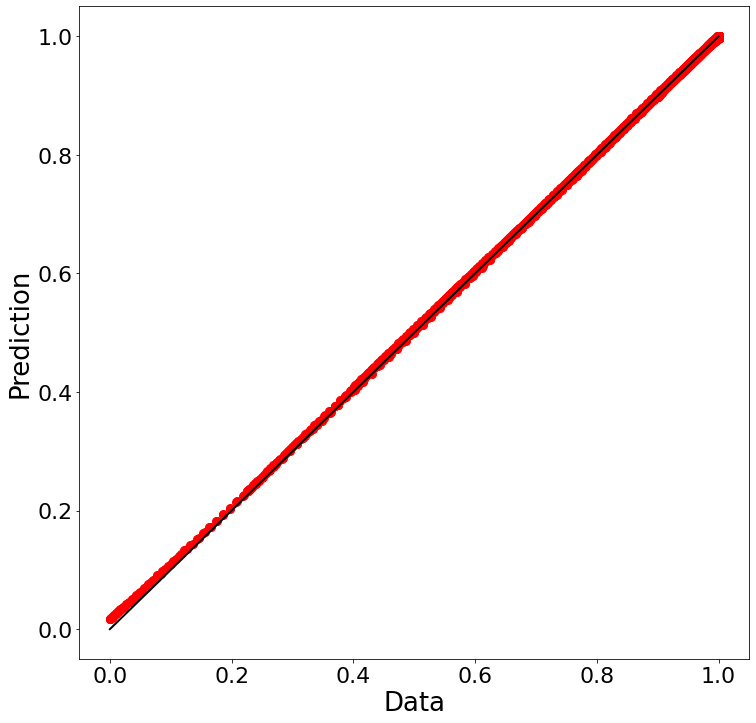

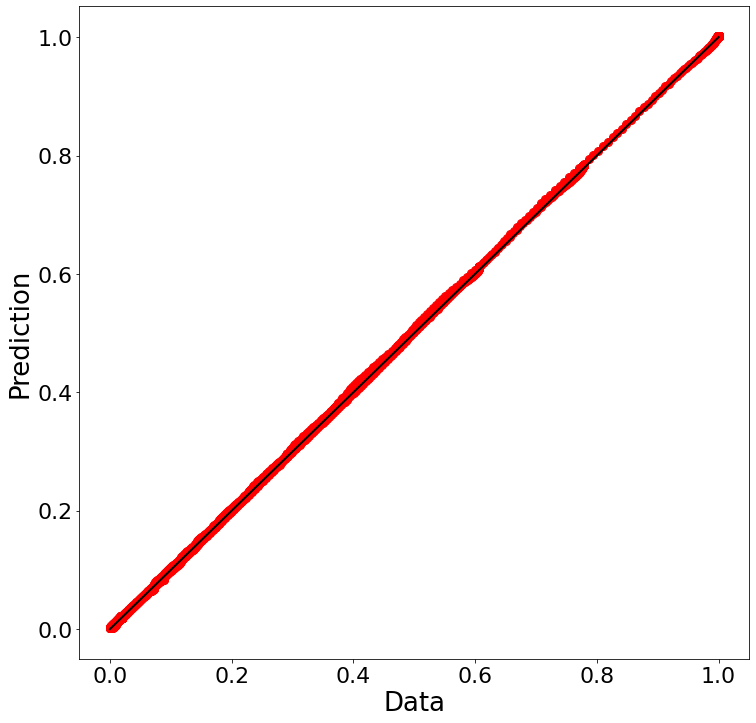

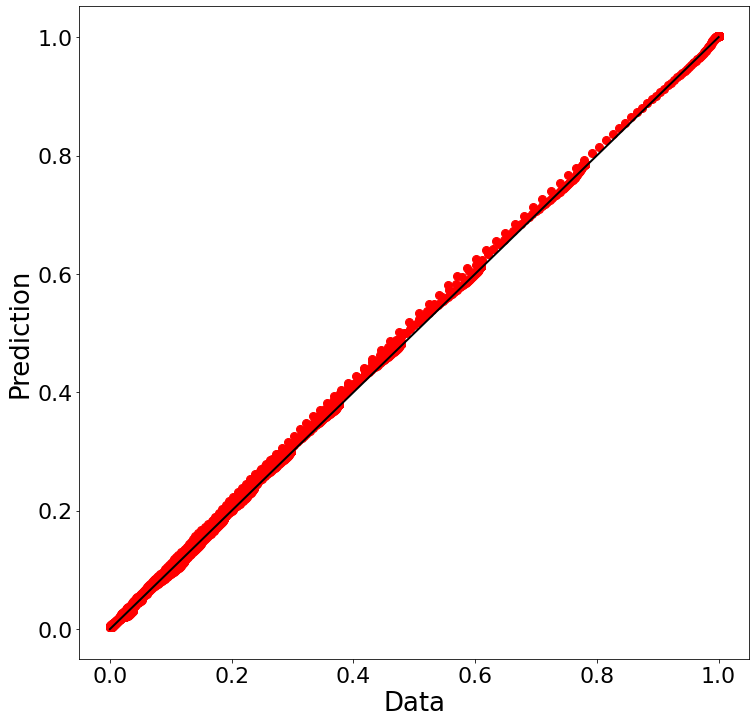

In [519]:
### Checking Predictive Accuracy

ySource_pca_ = NNModel.predict(yMatt_pca)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee_pca[:,iy])
    xMax_ = np.amax(ySourcee_pca[:,iy])
    plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

In [520]:
# NNModel = []

# for iy in range(1,2):


#     ### Creating Surrogate

#     LengthScale               = 5.e-2
#     Tau                       = 1.
#     RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

#     NNModel.append(tf.keras.models.Sequential())

#     NNModel[-1].add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     for iHL in range(1, len(NNeurons)):
#         NNModel[-1].add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
#     NNModel[-1].add(Dense(Ny, activation='linear'))
#     NNModel[-1].summary()



#     ### Training Surrogate

#     Optimizer = OptimizerName(learning_rate=LearningRate)
#     NNModel[-1].compile(optimizer=Optimizer, loss='mse')
#     Training  = NNModel[-1].fit(XTrain, yTrain[:,iy], batch_size=NBatch, epochs=1000, validation_data=(XTest, yTest[:,iy]), verbose=1);

#     LossTrainHystory = Training.history['loss']
#     LossValidHystory = Training.history['val_loss']



#     # Plotting Training and Validation Loss

#     fig = plt.figure(figsize=(12, 8))
#     plt.plot(LossTrainHystory, 'r', label='Training')
#     plt.plot(LossValidHystory, 'g', label='Validation')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.yscale('log')
#     plt.legend()
# #     FigPath = FigDir+'/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
# #     fig.savefig(FigPath, dpi=900)
    
    
    
#     ### Checking Predictive Accuracy

#     ySource_pca_ = NNModel[-1].predict(yMatt_pca)

#     fig  = plt.figure(figsize=(12,12))
#     xMin_ = np.amin(ySourcee_pca[:,iy])
#     xMax_ = np.amax(ySourcee_pca[:,iy])
#     plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
#     plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
#     plt.xlabel('Data')
#     plt.ylabel('Prediction')

In [521]:
# ySource_pca_ = NNModel[-1].predict(yMatt_pca)

# fig  = plt.figure(figsize=(12,12))
# xMin_ = np.amin(ySourcee_pca[:,iy])
# xMax_ = np.amax(ySourcee_pca[:,iy])
# plt.plot(ySourcee_pca[:,iy], ySource_pca_[:,iy], 'ro')
# plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
# plt.xlabel('Data')
# plt.ylabel('Prediction')

In [522]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    print(t)
    #yy   = (y - xMin)/xRange
    yy   = (np.append(y, RestVal) - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

y0_pca =  [2.70169506e+02 1.30611805e-02 1.26618271e-03]
0.0
2.30474006815266e-08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.614865962903741e-08
2.614865962903741e-08
5.229731925807482e-08
5.229731925807482e-08
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
3.137839155484489e-07
1.8304061740326187e-07
1.8304061740326187e-07
1.1766896833066834e-07
1.1766896833066834e-07
1.8304061740326187e-07
1.8304061740326187e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
8.367571081291971e-07
1.4904735988551324e-06
1.4904735988551324e-06
1.340363869014982e-06
1.340363869014982e-06
1.8439706299007667e-06
1.8439706299007667e-06
2.3475773907865515e-06
2.3475773907865515e-06
3.930978565481811e-06
3.930978565481811e-0

0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006246378450605508
0.0006246378450605508
0.0006246378450605508
0.0006539009126767143
0.0006539009126767143
0.0006539009126767143
0.0006831639802928778
0.0006831639802928778
0.0006831639802928778
0.0007124270479090413
0.0007124270479090413
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007769273860599935
0.0007446772169845174
0.0007446772169845174
0.0007285521324467794
0.0007285521324467794
0.0007204895901779104
0.0007204895901779104
0.0007164583190434758
0.0007164583190434758
0.0007144426834762585
0.0007144426834762585
0.0007134348656926499
0.0007134348656926499
0.0007129309568008457
0.0007129309568008457
0.00071343486569265
0.00071343486569265
0.00071343486569265
0.00071343486569265
0.00071343486569265
0.00071343486569265


0.0017621665657834103
0.0017621665657834103
0.0017621665657834103
0.0017621665657834103
0.0017621665657834103
0.0017621665657834103
0.0016688174414572084
0.0016688174414572084
0.0016221428792941076
0.0016221428792941076
0.0015988055982125572
0.0015988055982125572
0.0016221428792941078
0.0016221428792941078
0.0016454801603756584
0.0016454801603756584
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.0018106955606778641
0.00197591096098007
0.00197591096098007
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.0021411263612822755
0.002058518661131173
0.002058518661131173
0.0020172148110556213
0.0020172148110556213
0.002058518661131173
0.002058518661131173
0.0020998225112067244
0.0020998225112067244
0.002325181459899785
0.002325181459899785
0.002325181459899785

0.011156552139008007
0.011156552139008007
0.011156552139008007
0.011156552139008007
0.010505670608855494
0.010505670608855494
0.010180229843779236
0.010180229843779236
0.010017509461241109
0.010017509461241109
0.009936149269972045
0.009936149269972045
0.009895469174337514
0.009895469174337514
0.009936149269972046
0.009936149269972046
0.00997682936560658
0.00997682936560658
0.010383630321951907
0.010383630321951907
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.010790431278297236
0.011982975562474896
0.011982975562474896
0.011982975562474896
0.013175519846652557
0.013175519846652557
0.013175519846652557
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.015898380959441728
0.014536950403047142
0.014536950403047142
0.01385623512484985
0.01385623512484985
0.013856235124849

0.021733871448614606
0.021733871448614606
0.021733871448614606
0.021733871448614606
0.021733871448614606
0.020221998500411453
0.020221998500411453
0.019466062026309877
0.019466062026309877
0.01908809378925909
0.01908809378925909
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.01946606202630988
0.019277077907784483
0.019277077907784483
0.019466062026309877
0.019466062026309877
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.01965504614483527
0.019560554085572574
0.019560554085572574
0.019513308055941224
0.019513308055941224
0.01948968504112555
0.01948968504112555
0.019477873533717716
0.019477873533717716
0.019489685041125554
0.019489685041125554
0.019501496548533392
0.019501496548533392
0.019619611622611777
0.019619611622611777
0.019619611622611777
0.019619611622611777
0.01961961162

0.02446138061771769
0.02446138061771769
0.02446138061771769
0.02446138061771769
0.02446138061771769
0.025073973567444452
0.025073973567444452
0.027367030906589578
0.027367030906589578
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.029660088245734705
0.02851355957616214
0.02851355957616214
0.02794029524137586
0.02794029524137586
0.02794029524137586
0.027653663073982718
0.027653663073982718
0.027940295241375857
0.027940295241375857
0.029552575402494244
0.029552575402494244
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.029999999999999995
0.02977628770124712
0.02977628770124712
0.029664431551870683
0.029664431551870683
0.02960850347718246
0.02960850347718246
0.029580539439838353
0.029580539439838353
0.029566557421166297
0.029566557421166297
0.02958053943983835
0.02958053943983835
0.029720

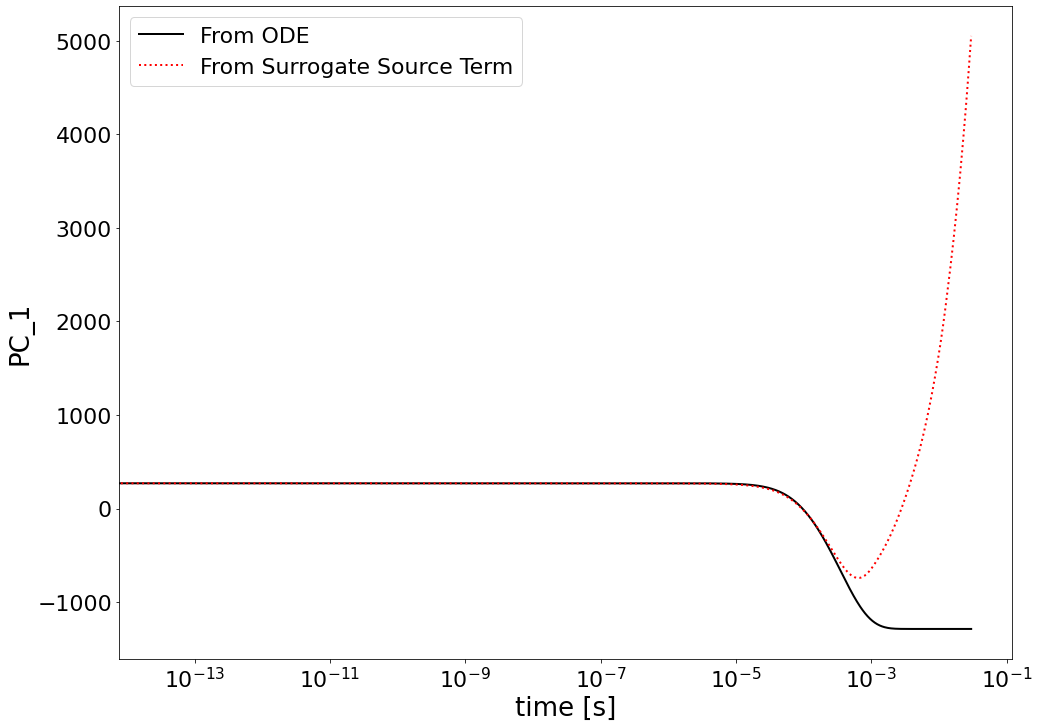

In [540]:
### Evaluating on Test Data

FileName       = TestDir + '/orig_data/RestVecTot.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat_pca     = Data[Vars].to_numpy()
    y0_pca       = yMat_pca[0,:]
    print('y0_pca = ', y0_pca)
    
    RestVal      = RestValVecTest[iTest]
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    output       = solve_ivp( fOrig_NN, tVec[[0,-1]], y0_pca, method='BDF', t_eval=tVec, atol=1.e-8 )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

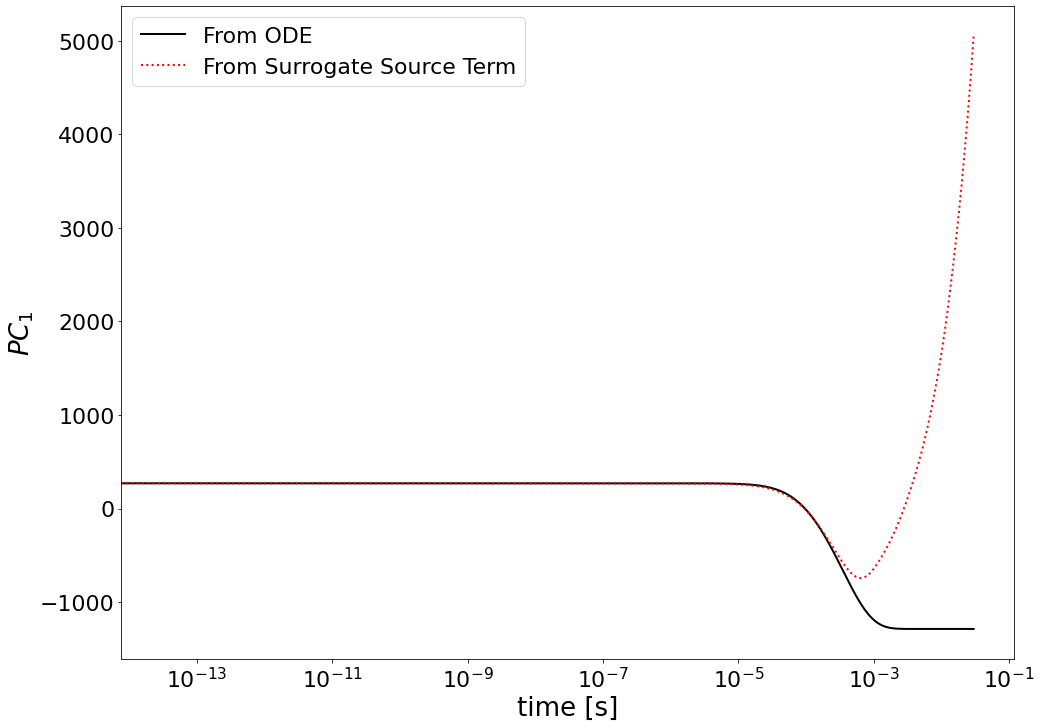

In [543]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()

In [504]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [505]:
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

iVar =  1


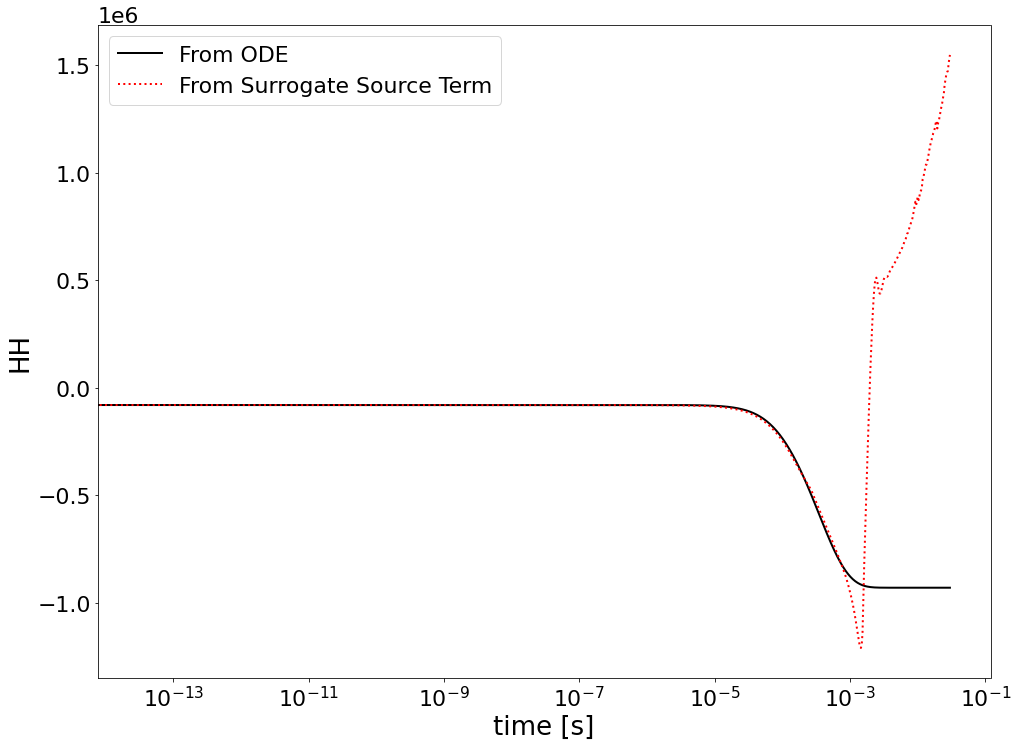

In [509]:
VarOI = 'HH'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in range(1):

    FileName     = TestDir+'/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1],   '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()